### Import libraries:

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load data:

In [2]:
data = pd.read_csv('../../data/clean/data_cleaned.csv')

data.head()

,gender,ethnicity,parental_education,lunch,test_preparation_course,pass/fail_math,math_score,pass/fail_reading,reading_score,pass/fail_writing,writing_score,failed_courses,midterm_results,average_grade
0,M,A,high school,standard,yes,passed,67,passed,67,passed,63,good standing,good standing,65.67
1,F,D,no high school,reduced,no,failed,40,failed,59,failed,55,math/reading,summer school,51.33
2,M,E,high school,reduced,no,failed,59,passed,60,failed,50,math/writing,summer school,56.33
3,M,B,high school,standard,no,passed,77,passed,78,passed,68,good standing,good standing,74.33
4,M,E,associate,standard,yes,passed,78,passed,73,passed,68,good standing,good standing,73.00


### X/y and numerical/categorical split:

In [3]:
X = data.drop(['math_score', 'reading_score', 'writing_score', 'average_grade'], axis=1)
y = data['average_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train_numerical = X_train.select_dtypes(np.number)
#X_test_numerical = X_test.select_dtypes(np.number)

X_train_categorical = X_train.select_dtypes(object)
X_test_categorical = X_test.select_dtypes(object)

### Encoding categoricals:

In [4]:
encoder = OneHotEncoder()
encoder.fit(X_train_categorical)

X_train_cat_enc = encoder.transform(X_train_categorical).toarray()
X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=encoder.get_feature_names_out())

X_test_cat_enc = encoder.transform(X_test_categorical).toarray()
X_test_cat_enc = pd.DataFrame(X_test_cat_enc, columns=encoder.get_feature_names_out())

### Standarizing numericals:

In [5]:
#scaler = StandardScaler()
#scaler.fit(X_train_numerical)

#X_train_num = scaler.transform(X_train_numerical)
#X_train_num = round(pd.DataFrame(X_train_num, columns=X_train_numerical.columns),4)

#X_test_num = scaler.transform(X_test_numerical)
#X_test_num = round(pd.DataFrame(X_test_num, columns=X_test_numerical.columns),4)
#X_test_num.head()

### Final datasets:

In [6]:
X_train_final = X_train_cat_enc
X_test_final = X_test_cat_enc

### Finding the best K-value:

In [7]:
def find_k(X_train, X_test, y_train, y_test, max_k=16):
    
    scores = []
    for k in range(2,max_k+1):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)
        
    plt.figure(figsize=(4,4))
    plt.plot(range(2, max_k+1), scores, marker='d', markersize=7)
    plt.title('R2 vs K-value')
    plt.xlabel('k')
    plt.ylabel('R2')
    plt.xticks(range(1, max_k+1))

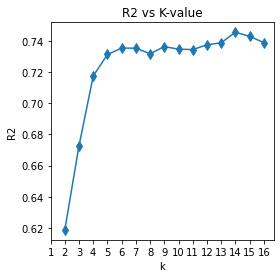

In [8]:
find_k(X_train_final, X_test_final, y_train, y_test)

k = 14 has the highest R2 value.

### KNeighborsRegressor:

In [9]:
knn = KNeighborsRegressor(14, weights='distance')

In [10]:
knn.fit(X_train_final, y_train)

KNeighborsRegressor(n_neighbors=14, weights='distance')

### Predictions:

In [11]:
y_train_pred = knn.predict(X_train_final)
y_test_pred = knn.predict(X_test_final)

### Validating the model:

In [12]:
def model_performance(y_train, y_train_pred, y_test, y_test_pred):

    ME_train = np.mean(y_train-y_train_pred)
    ME_test  = np.mean(y_test-y_test_pred)

    MAE_train = mean_absolute_error(y_train,y_train_pred)
    MAE_test  = mean_absolute_error(y_test,y_test_pred)

    MSE_train = mean_squared_error(y_train,y_train_pred)
    MSE_test  = mean_squared_error(y_test,y_test_pred)

    RMSE_train = np.sqrt(MSE_train)
    RMSE_test  = np.sqrt(MSE_test)

    MAPE_train = np.mean((np.abs(y_train-y_train_pred) / y_train)* 100.)
    MAPE_test  = np.mean((np.abs(y_test-y_test_pred) / y_test)* 100.)

    R2_train = r2_score(y_train,y_train_pred)
    R2_test  = r2_score(y_test,y_test_pred)

    performance = pd.DataFrame({'Error_metric': ['Mean error','Mean absolute error','Mean squared error',
                                             'Root mean squared error','Mean absolute percentual error',
                                             'R2'],
                            'Train': [ME_train, MAE_train, MSE_train, RMSE_train, MAPE_train, R2_train],
                            'Test' : [ME_test, MAE_test , MSE_test, RMSE_test, MAPE_test, R2_test]})

    pd.options.display.float_format = '{:.2f}'.format

    df_train = pd.DataFrame({'Real': y_train.tolist(), 'Predicted': y_train_pred.tolist()})
    df_test  = pd.DataFrame({'Real': y_test.tolist(),  'Predicted': y_test_pred.tolist()})

    return performance, df_train, df_test

In [13]:
model_performance(y_train, y_train_pred, y_test, y_test_pred)

(                     Error_metric  Train  Test
 0                      Mean error  -0.06  0.19
 1             Mean absolute error   3.77  6.08
 2              Mean squared error  32.39 62.06
 3         Root mean squared error   5.69  7.88
 4  Mean absolute percentual error   5.63  9.31
 5                              R2   0.85  0.70,
      Real  Predicted
 0   76.00      76.20
 1   59.67      63.73
 2   82.33      88.33
 3   42.67      42.83
 4   48.00      49.34
 ..    ...        ...
 695 76.33      77.31
 696 71.33      71.58
 697 93.33      83.67
 698 84.33      76.66
 699 78.00      75.00
 
 [700 rows x 2 columns],
      Real  Predicted
 0   76.67      81.66
 1   82.00      73.50
 2   52.00      45.22
 3   92.00      78.67
 4   69.67      65.67
 ..    ...        ...
 295 65.00      75.00
 296 80.00      73.05
 297 51.33      48.00
 298 88.33      86.34
 299 44.67      49.78
 
 [300 rows x 2 columns])

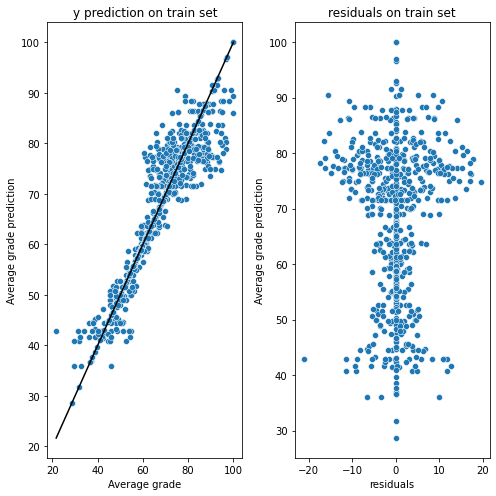

In [14]:
residuals_train = y_train - y_train_pred

fig, ax = plt.subplots(1,2, figsize=(7,7))
line = [y.min(), y.max()]

plot_1 = sns.scatterplot(y=y_train_pred, x=y_train, ax=ax[0])
plot_1 = sns.lineplot(y=line, x=line, ax=ax[0], color='black')
plot_1.set(title='y prediction on train set', xlabel='Average grade', ylabel='Average grade prediction')

plot_2 = sns.scatterplot(y=y_train_pred, x=residuals_train, ax=ax[1])
plot_2.set(title='residuals on train set', xlabel='residuals', ylabel='Average grade prediction')


plt.tight_layout()
plt.show()

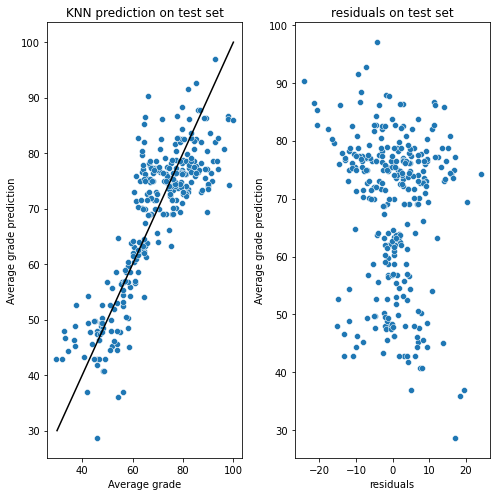

In [18]:
residuals_test = y_test - y_test_pred

fig, ax = plt.subplots(1,2, figsize=(7,7))
line = [30, y.max()]

plot_1 = sns.scatterplot(y=y_test_pred, x=y_test, ax=ax[0])
plot_1 = sns.lineplot(y=line, x=line, ax=ax[0], color='black')
plot_1.set(title='KNN prediction on test set', xlabel='Average grade', ylabel='Average grade prediction')

plot_2 = sns.scatterplot(y=y_test_pred, x=residuals_test, ax=ax[1])
plot_2.set(title='residuals on test set', xlabel='residuals', ylabel='Average grade prediction')


plt.tight_layout()
plt.show()

### Storing predictions in the dataframe:

In [17]:
y_test_pred_df = pd.DataFrame(y_test_pred)

df = data.copy()

df['average_grade_pred_knn'] = y_test_pred_df

df.dropna(inplace=True)

df.to_csv('knn_regressor_pred.csv', index_label = False)

### Saving the model:

In [19]:
pickle.dump(knn, open('knn_regression.pkl', 'wb'))